In [1]:
import pandas as pd
import hddm

data = hddm.load_csv('data_preprocessed.csv', index_col=0)

/anaconda3/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
data.head()

,subj_idx,response,rt,gain,loss
0,1,1.0,2.388,14,-6
1,1,1.0,2.289,34,-14
2,1,1.0,1.873,34,-13
3,1,0.0,1.457,10,-10
4,1,0.0,1.973,12,-19


In [3]:
m = hddm.models.HDDMRegressor(data, ['v ~ gain + loss'], group_only_regressors=False)

Adding these covariates:
['v_Intercept', 'v_gain', 'v_loss']


In [4]:
m.find_starting_values()

/anaconda3/lib/python2.7/site-packages/scipy/optimize/optimize.py:1934: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/anaconda3/lib/python2.7/site-packages/scipy/optimize/optimize.py:1935: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


In [ ]:
import os
modelName = 'no_predecisional_bias'
if not os.path.exists('savedModels/{}'.format(modelName)):
    os.makedirs('savedModels/{}'.format(modelName))

m.sample(5000, burn=1000, dbname='savedModels/{}/db_{}'.format(modelName, modelName), db='pickle')

 [                  0%                  ] 3 of 5000 complete in 9.2 sec

In [6]:
m.save('savedModels/{}/{}'.format(modelName, modelName))

In [4]:
modelName = 'no_predecisional_bias'
m = hddm.load('savedModels/{}/{}'.format(modelName, modelName))

## Model parameters

In [7]:
m.print_stats()

                           mean         std       2.5q          25q         50q         75q       97.5q       mc err
a                       2.59697   0.0549265    2.49229      2.55964     2.59721     2.63511      2.7062   0.00114019
a_std                  0.388614   0.0418889   0.316445     0.359683    0.385092    0.414332    0.482925   0.00100735
a_subj.1                2.53764    0.118893    2.30917      2.45622     2.53503      2.6172     2.78309   0.00406474
a_subj.3                2.90404    0.113598    2.68431      2.82719     2.89992     2.98124     3.13193   0.00335848
a_subj.5                2.10496   0.0728885    1.96786      2.05465     2.10275     2.15326      2.2591   0.00202451
a_subj.9                2.82058    0.128046    2.57836      2.73238     2.81691     2.90392     3.08564   0.00469539
a_subj.11               2.43946    0.124476    2.21464      2.35105     2.43413     2.52142     2.68955   0.00437823
a_subj.13               1.76246   0.0849913     1.6069      1.70

$\lambda$

In [21]:
import numpy as np

In [22]:
modelParamsDF = m.nodes_db
modelParamsDF.to_csv("fullModel_params.csv")

# group level mean of lambda
groupLevelMeanOfLambda = modelParamsDF.loc['v_loss', 'mean']/modelParamsDF.loc['v_gain', 'mean']
print("group level mean of lamdba is: ", groupLevelMeanOfLambda)

# 95% CI for beta_G, beta_L
print("2.5% percentile for beta_L: ", modelParamsDF.loc['v_loss', '2.5q'])
print("97.5% percentile for beta_G: ", modelParamsDF.loc['v_gain', '97.5q'])

('group level mean of lamdba is: ', 0.9892438129238994)
('2.5% percentile for beta_L: ', 0.17724322130635456)
('97.5% percentile for beta_G: ', 0.212914203306288)


In [35]:
allSubjectsIndex = list(set(data['subj_idx']))
print(allSubjectsIndex)

[2, 4, 6, 8, 10, 14, 16, 18, 20, 22, 24, 26, 30, 32, 36, 38, 40, 44, 46, 50, 52, 54, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 80, 82, 84, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 124]


In [36]:
# how many participants have beta_L > beta_G, how many have the 95% CI greater?
# participant level mean (SD) of lambda
numLambdaMean = 0
numLambdaCI = 0
allParticipantLambdas = []

for subjectIndex in allSubjectsIndex:
    beta_gain = modelParamsDF.loc['v_gain_subj.{}'.format(subjectIndex), 'mean']
    beta_loss = modelParamsDF.loc['v_loss_subj.{}'.format(subjectIndex), 'mean']
    beta_L_lowerBound = modelParamsDF.loc['v_loss_subj.{}'.format(subjectIndex), '2.5q']
    beta_G_upperBound = modelParamsDF.loc['v_gain_subj.{}'.format(subjectIndex), '97.5q']
    
    if beta_loss > beta_gain:
        numLambdaMean += 1
        
    if beta_L_lowerBound > beta_G_upperBound:
        numLambdaCI += 1
        
    lambdaForThisParticipant = beta_loss/beta_gain
    allParticipantLambdas.append(lambdaForThisParticipant)

print("Number of people with beta_L > beta_G = ", numLambdaMean)
# print("Number of people with 95% CI of beta_L > beta_G = ", numLambdaCI)
print("Average lambda over all individuals = {} ({})".format(np.mean(allParticipantLambdas), np.std(allParticipantLambdas)))

('Number of people with beta_L > beta_G = ', 23)
Average lambda over all individuals = 1.03934740913 (0.403649897853)


In [37]:
print("beta_L mean:", modelParamsDF.loc['v_loss', 'mean'])
print("beta_L 2.5q:", modelParamsDF.loc['v_loss', '2.5q'])
print("beta_L 97.5q:", modelParamsDF.loc['v_loss', '97.5q'])
print("beta_L median", modelParamsDF.loc['v_loss', '50q'])
print("beta_L SD", modelParamsDF.loc['v_loss', 'std'])

print("beta_G mean:", modelParamsDF.loc['v_gain', 'mean'])
print("beta_G 2.5q:", modelParamsDF.loc['v_gain', '2.5q'])
print("beta_G 97.5q:", modelParamsDF.loc['v_gain', '97.5q'])
print("beta_G median", modelParamsDF.loc['v_gain', '50q'])
print("beta_G SD", modelParamsDF.loc['v_gain', 'std'])

('beta_L mean:', 0.19404572964065595)
('beta_L 2.5q:', 0.17724322130635456)
('beta_L 97.5q:', 0.2101898918405959)
('beta_L median', 0.1941494049055793)
('beta_L SD', 0.008295547369446083)
('beta_G mean:', 0.19615561614392782)
('beta_G 2.5q:', 0.17940866313693193)
('beta_G 97.5q:', 0.212914203306288)
('beta_G median', 0.19633739141122156)
('beta_G SD', 0.008522921390413643)


$\gamma$

In [3]:
meanA = modelParamsDF.loc['a', 'mean']
print("mean value of threshold: ", meanA)

# 95 CI interval
Z_CI_lowerBound = (modelParamsDF.loc['z'.format(subjectIndex), '2.5q'] - 0.5)*meanA
Z_CI_upperBound = (modelParamsDF.loc['z'.format(subjectIndex), '97.5q'] - 0.5)*meanA
print("confidence interval of gamma: ", Z_CI_lowerBound, Z_CI_upperBound)

NameError: name 'modelParamsDF' is not defined

In [39]:
# mean gamma across all participants, how many participants have 95% CI of gamma strictly negative
allParticipantsZ = []
countGammaMean = 0
countGammaCI = 0

for participantIndex in allSubjectsIndex:
    a_participant = modelParamsDF.loc['a_subj.{}'.format(participantIndex), 'mean']
    z_participant = (modelParamsDF.loc['z_subj.{}'.format(participantIndex), 'mean'] - 0.5)*meanA
    allParticipantsZ.append(z_participant)
    z_upperBound_participant = (modelParamsDF.loc['z_subj.{}'.format(participantIndex), '97.5q'] - 0.5)*meanA
    
    if z_upperBound_participant < 0:
        countGammaCI += 1
        
    if z_participant < 0:
        countGammaMean += 1
    
mean_Z = np.mean(allParticipantsZ)
SD_Z = np.std(allParticipantsZ)
print("Mean value of pre-valuation bias across all participants: {} ({})".format(mean_Z, SD_Z))
print("Number of participants with negative gamma: ", countGammaMean)
print("Number of participants with 95% CI of gamma negative: ", countGammaCI)

Mean value of pre-valuation bias across all participants: 0.0733542161789 (0.115491182766)
('Number of participants with negative gamma: ', 12)
('Number of participants with 95% CI of gamma negative: ', 5)


In [40]:
print("gamma mean:", (modelParamsDF.loc['z', 'mean'] - 0.5)*meanA)
print("gamma 2.5q:", (modelParamsDF.loc['z', '2.5q'] - 0.5)*meanA)
print("gamma 97.5q:", (modelParamsDF.loc['z', '97.5q'] - 0.5)*meanA)
print("gamma median", (modelParamsDF.loc['z', '50q'] - 0.5)*meanA)
print("gamma SD", (modelParamsDF.loc['z', 'std'])*meanA)

('gamma mean:', 0.07380431996154235)
('gamma 2.5q:', 0.03883826722659351)
('gamma 97.5q:', 0.10902757078957957)
('gamma median', 0.07381811370767026)
('gamma SD', 0.017797152022404335)


$\alpha$

In [41]:
# group-level mean
print("Group-level mean of alpha is: ", modelParamsDF.loc['v_Intercept'.format(subjectIndex), 'mean'])

# how many participants have mean and 95% CI negative?
allParticipantsAlphas = []
countAlphaMean = 0
countAlphaCI = 0

for participantIndex in allSubjectsIndex:
    alpha_participant = modelParamsDF.loc['v_Intercept_subj.{}'.format(participantIndex), 'mean']
    allParticipantsAlphas.append(alpha_participant)
    alpha_upperBound_participant = modelParamsDF.loc['v_Intercept_subj.{}'.format(participantIndex), '97.5q']
    
    if alpha_upperBound_participant < 0:
        countAlphaCI += 1
        
    if alpha_participant < 0:
        countAlphaMean += 1
        
mean_alpha = np.mean(allParticipantsAlphas)
SD_alpha = np.std(allParticipantsAlphas)
print("Mean value of fixed utility bias across all participants: {} ({})".format(mean_alpha, SD_alpha))
print("Number of participants with negative alpha: ", countAlphaMean)
print("Number of participants with 95% CI of alpha negative: ", countAlphaCI)

('Group-level mean of alpha is: ', -0.25578953632632334)
Mean value of fixed utility bias across all participants: -0.258924422834 (0.749343238833)
('Number of participants with negative alpha: ', 40)
('Number of participants with 95% CI of alpha negative: ', 20)


In [42]:
print("alpha mean:", modelParamsDF.loc['v_Intercept', 'mean'])
print("alpha 2.5q:", modelParamsDF.loc['v_Intercept', '2.5q'])
print("alpha 97.5q:", modelParamsDF.loc['v_Intercept', '97.5q'])
print("alpha median", modelParamsDF.loc['v_Intercept', '50q'])
print("alpha SD", modelParamsDF.loc['v_Intercept', 'std'])

('alpha mean:', -0.25578953632632334)
('alpha 2.5q:', -0.4914182484989258)
('alpha 97.5q:', -0.0268709179129501)
('alpha median', -0.25319668404167733)
('alpha SD', 0.11799163007279757)


# Correlation with rejection rates

In [52]:
def getPAcceptFromSubjectIndex(subjectIndex):
    subjectResponses = np.array(data.loc[data['subj_idx'] == subjectIndex]['response'])
    return np.mean(subjectResponses)

allParticipants_p_accept = np.array([getPAcceptFromSubjectIndex(subjectIndex) for subjectIndex in allSubjectsIndex])
allParticipants_p_accept

array([0.47265625, 0.54365079, 0.4296875 , 0.17578125, 0.54761905,
       0.5390625 , 0.48627451, 0.34901961, 0.5498008 , 0.15294118,
       0.23921569, 0.49583333, 0.51171875, 0.39607843, 0.65322581,
       0.32421875, 0.29296875, 0.546875  , 0.5254902 , 0.48207171,
       0.62890625, 0.52777778, 0.5546875 , 0.55378486, 0.203125  ,
       0.51953125, 0.39215686, 0.54296875, 0.49802372, 0.33606557,
       0.48046875, 0.10196078, 0.5703125 , 0.71146245, 0.36328125,
       0.45454545, 0.5254902 , 0.41338583, 0.26190476, 0.52988048,
       0.734375  , 0.3015873 , 0.49609375, 0.375     , 0.4375    ,
       0.42745098, 0.39920949, 0.37109375, 0.6484375 , 0.53125   ,
       0.58039216, 0.24899598, 0.36328125])

In [44]:
from scipy.stats.stats import pearsonr
import seaborn as sns
from matplotlib import pyplot as plt

('Pearson correlation between Lambda and P(Acceptance) is: ', (-0.1164417230154428, 0.4063552909865634))


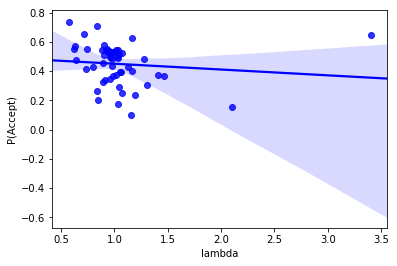

In [45]:
sns.regplot(allParticipantLambdas, allParticipants_p_accept, color ='blue')
plt.xlabel("lambda")
plt.ylabel("P(Accept)")
print("Pearson correlation between Lambda and P(Acceptance) is: ", pearsonr(allParticipantLambdas, allParticipants_p_accept))

('Pearson correlation between gamma and P(Acceptance) is: ', (0.30121858064123674, 0.028394152446444672))


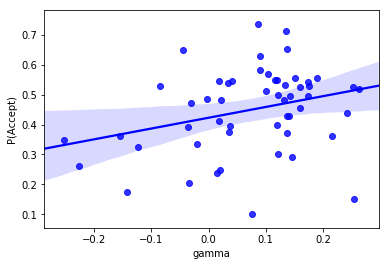

In [46]:
sns.regplot(allParticipantsZ, allParticipants_p_accept, color ='blue')
plt.xlabel("gamma")
plt.ylabel("P(Accept)")
print("Pearson correlation between gamma and P(Acceptance) is: ", pearsonr(allParticipantsZ, allParticipants_p_accept))

('Pearson correlation between alpha and P(Acceptance) is: ', (0.5233776762917193, 5.789938726159638e-05))


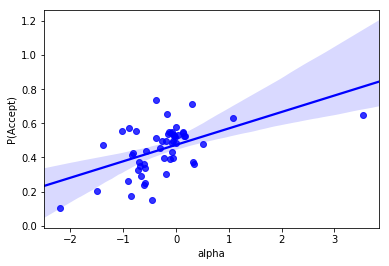

In [47]:
sns.regplot(allParticipantsAlphas, allParticipants_p_accept, color ='blue')
plt.xlabel("alpha")
plt.ylabel("P(Accept)")
print("Pearson correlation between alpha and P(Acceptance) is: ", pearsonr(allParticipantsAlphas, allParticipants_p_accept))

# Correlation with lambda (traditional method -- computed using logistic regression)

In [48]:
import matplotlib
matplotlib.rcParams.update({'font.size': 30})

In [62]:
from sklearn.linear_model import LogisticRegression
allSubjectsIndex = np.array(allSubjectsIndex)
indicesToAnalyze = allSubjectsIndex[allParticipants_p_accept[:] != 0]

def computeParticipantLambdaLR(subjectIndex):
    participantData = data[data['subj_idx'] == subjectIndex]
    X = participantData[['gain', 'loss']]
    y = participantData['response']
    classifier = LogisticRegression().fit(X, y)
    coefficients = classifier.coef_
    participantLambdaLR = coefficients[0][1]/coefficients[0][0]
    return participantLambdaLR

allParticipantLambdasLR = [computeParticipantLambdaLR(_) for _ in indicesToAnalyze]

In [74]:
print("Lambda computed using logistic regression, mean: {}, SD: {}".format(np.mean(allParticipantLambdasLR), np.std(allParticipantLambdasLR)))

Lambda computed using logistic regression, mean: 1.10382594755, SD: 0.346983127451


('Pearson correlation between P(accept) and Logistic regression lambda is: ', (-0.5169056137104109, 7.407663440934988e-05))


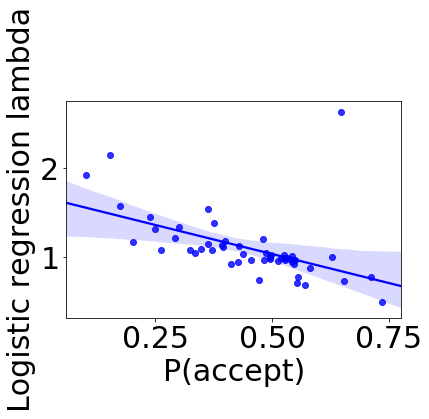

In [73]:
# fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
# pAcceptToCorrelate = np.array(allParticipants_p_accept)[indicesToAnalyze]
sns.regplot(allParticipants_p_accept, allParticipantLambdasLR, color ='blue')
plt.xlabel("P(accept)")
plt.ylabel("Logistic regression lambda")
print("Pearson correlation between P(accept) and Logistic regression lambda is: ", pearsonr(allParticipants_p_accept, allParticipantLambdasLR))

('Pearson correlation between DDM lambda and Logistic regression lambda is: ', (0.885060416833026, 1.4440564188241921e-18))


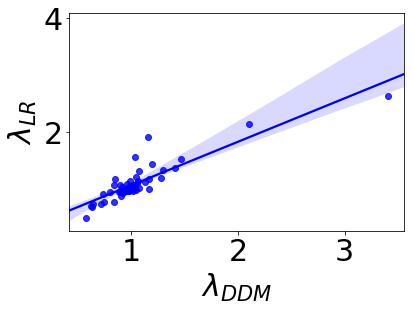

In [72]:
# fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
# lambdasToCorrelate = np.array(allParticipantLambdas)[indicesToAnalyze]
sns.regplot(allParticipantLambdas, allParticipantLambdasLR, color ='blue')
plt.xlabel(r"$\lambda_{DDM}$")
plt.ylabel(r"$\lambda_{LR}$")
print("Pearson correlation between DDM lambda and Logistic regression lambda is: ", pearsonr(allParticipantLambdas, allParticipantLambdasLR))

('Pearson correlation between gamma and Logistic regression lambda is: ', (-0.10526245646505697, 0.45317235738639483))


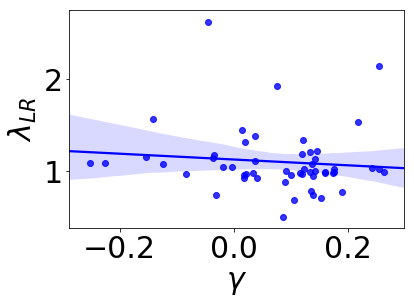

In [70]:
# fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
# gammasToCorrelate = np.array(allParticipantsZ)[indicesToAnalyze]
sns.regplot(allParticipantsZ, allParticipantLambdasLR, color ='blue')
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$\lambda_{LR}$")
print("Pearson correlation between gamma and Logistic regression lambda is: ", pearsonr(allParticipantsZ, allParticipantLambdasLR))

('Pearson correlation between alpha and Logistic regression lambda is: ', (0.3349783567458889, 0.014213540602165885))


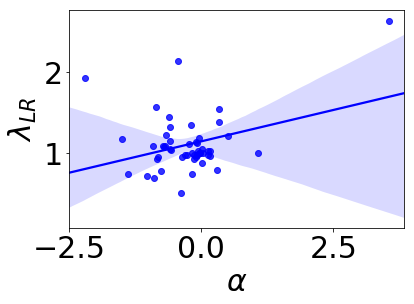

In [71]:
# fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
# alphasToCorrelate = np.array(allParticipantsAlphas)[indicesToAnalyze]
sns.regplot(allParticipantsAlphas, allParticipantLambdasLR, color ='blue')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\lambda_{LR}$")
print("Pearson correlation between alpha and Logistic regression lambda is: ", pearsonr(allParticipantsAlphas, allParticipantLambdasLR))

In [18]:
m.save('fullModel')

# Compute R-hat

In [1]:
def run_model(id):
    import pandas as pd
    import hddm

    data = hddm.load_csv('/Users/nishadsinghi/undergrad-project-loss-aversion/dataset3/dataset3_preprocessed.csv', index_col=0)

    m = hddm.models.HDDMRegressor(data, ['v ~ gain + loss'], include=('z'), group_only_regressors=False)
    m.find_starting_values()
    m.sample(4000, burn=1000, dbname='fullModel_db%i'%id, db='pickle')
    return m

In [2]:
from kabuki.analyze import gelman_rubin

In [ ]:
from ipyparallel import Client
v = Client()[:]
jobs = v.map(run_model, range(4)) # 4 is the number of CPUs
models = jobs.get()
statistic = gelman_rubin(models)

# Simulate data from model

In [5]:
ppc_data = hddm.utils.post_pred_gen(m, samples=50, progress_bar=True)

 [------------------105%------------------] 57 of 54 complete in 16210.2 sec

In [6]:
import numpy as np
dataArray = np.genfromtxt("data_preprocessed.csv", delimiter=',')
dataArray = dataArray[1:, 1:]
print(dataArray[:5, :])

def extractStakesFromParticipantIndex(participantIndex):
    participantData = dataArray[dataArray[:, 0] == participantIndex][:]
    participantStakes = participantData[:, -2:]
    return participantStakes

[[  1.      1.      2.388  14.     -6.   ]
 [  1.      1.      2.289  34.    -14.   ]
 [  1.      1.      1.873  34.    -13.   ]
 [  1.      0.      1.457  10.    -10.   ]
 [  1.      0.      1.973  12.    -19.   ]]


In [7]:
import numpy as np

overallData = np.zeros((1, 5))

for (node, sample), sim_data in ppc_data.groupby(level=(0, 1)):
    print("-------")
    print("node: ", node)
    sim_data_array = np.asarray(sim_data)
    numTrials = np.shape(sim_data_array)[0]
    print("number of trials: ", numTrials)
    participantIndex = int(filter(str.isdigit, node))
    participantStakes = extractStakesFromParticipantIndex(participantIndex)
    participantIndexArray = np.full((numTrials, 1), participantIndex)
    responsesArray = np.zeros((numTrials, 1))
    responsesArray[sim_data_array[:, 0] > 0] = 1
    reactionTimesArray = np.abs(sim_data_array)
    sim_data_modified = np.hstack((participantIndexArray, responsesArray, reactionTimesArray, participantStakes))
    overallData = np.vstack((overallData, sim_data_modified))
    
print(np.shape(overallData))

-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('

-------
('node: ', 'wfpt.107')
('number of trials: ', 252)
-------
('node: ', 'wfpt.107')
('number of trials: ', 252)
-------
('node: ', 'wfpt.107')
('number of trials: ', 252)
-------
('node: ', 'wfpt.107')
('number of trials: ', 252)
-------
('node: ', 'wfpt.107')
('number of trials: ', 252)
-------
('node: ', 'wfpt.107')
('number of trials: ', 252)
-------
('node: ', 'wfpt.107')
('number of trials: ', 252)
-------
('node: ', 'wfpt.107')
('number of trials: ', 252)
-------
('node: ', 'wfpt.107')
('number of trials: ', 252)
-------
('node: ', 'wfpt.107')
('number of trials: ', 252)
-------
('node: ', 'wfpt.107')
('number of trials: ', 252)
-------
('node: ', 'wfpt.107')
('number of trials: ', 252)
-------
('node: ', 'wfpt.107')
('number of trials: ', 252)
-------
('node: ', 'wfpt.107')
('number of trials: ', 252)
-------
('node: ', 'wfpt.107')
('number of trials: ', 252)
-------
('node: ', 'wfpt.107')
('number of trials: ', 252)
-------
('node: ', 'wfpt.107')
('number of trials: ', 25

-------
('node: ', 'wfpt.113')
('number of trials: ', 255)
-------
('node: ', 'wfpt.113')
('number of trials: ', 255)
-------
('node: ', 'wfpt.113')
('number of trials: ', 255)
-------
('node: ', 'wfpt.113')
('number of trials: ', 255)
-------
('node: ', 'wfpt.113')
('number of trials: ', 255)
-------
('node: ', 'wfpt.113')
('number of trials: ', 255)
-------
('node: ', 'wfpt.113')
('number of trials: ', 255)
-------
('node: ', 'wfpt.113')
('number of trials: ', 255)
-------
('node: ', 'wfpt.113')
('number of trials: ', 255)
-------
('node: ', 'wfpt.113')
('number of trials: ', 255)
-------
('node: ', 'wfpt.113')
('number of trials: ', 255)
-------
('node: ', 'wfpt.113')
('number of trials: ', 255)
-------
('node: ', 'wfpt.113')
('number of trials: ', 255)
-------
('node: ', 'wfpt.113')
('number of trials: ', 255)
-------
('node: ', 'wfpt.113')
('number of trials: ', 255)
-------
('node: ', 'wfpt.113')
('number of trials: ', 255)
-------
('node: ', 'wfpt.113')
('number of trials: ', 25

-------
('node: ', 'wfpt.119')
('number of trials: ', 250)
-------
('node: ', 'wfpt.119')
('number of trials: ', 250)
-------
('node: ', 'wfpt.119')
('number of trials: ', 250)
-------
('node: ', 'wfpt.119')
('number of trials: ', 250)
-------
('node: ', 'wfpt.119')
('number of trials: ', 250)
-------
('node: ', 'wfpt.119')
('number of trials: ', 250)
-------
('node: ', 'wfpt.119')
('number of trials: ', 250)
-------
('node: ', 'wfpt.119')
('number of trials: ', 250)
-------
('node: ', 'wfpt.119')
('number of trials: ', 250)
-------
('node: ', 'wfpt.119')
('number of trials: ', 250)
-------
('node: ', 'wfpt.119')
('number of trials: ', 250)
-------
('node: ', 'wfpt.119')
('number of trials: ', 250)
-------
('node: ', 'wfpt.119')
('number of trials: ', 250)
-------
('node: ', 'wfpt.119')
('number of trials: ', 250)
-------
('node: ', 'wfpt.119')
('number of trials: ', 250)
-------
('node: ', 'wfpt.119')
('number of trials: ', 250)
-------
('node: ', 'wfpt.119')
('number of trials: ', 25

('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wf

-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node

-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node

-------
('node: ', 'wfpt.33')
('number of trials: ', 253)
-------
('node: ', 'wfpt.33')
('number of trials: ', 253)
-------
('node: ', 'wfpt.33')
('number of trials: ', 253)
-------
('node: ', 'wfpt.33')
('number of trials: ', 253)
-------
('node: ', 'wfpt.33')
('number of trials: ', 253)
-------
('node: ', 'wfpt.33')
('number of trials: ', 253)
-------
('node: ', 'wfpt.33')
('number of trials: ', 253)
-------
('node: ', 'wfpt.33')
('number of trials: ', 253)
-------
('node: ', 'wfpt.33')
('number of trials: ', 253)
-------
('node: ', 'wfpt.33')
('number of trials: ', 253)
-------
('node: ', 'wfpt.33')
('number of trials: ', 253)
-------
('node: ', 'wfpt.33')
('number of trials: ', 253)
-------
('node: ', 'wfpt.33')
('number of trials: ', 253)
-------
('node: ', 'wfpt.33')
('number of trials: ', 253)
-------
('node: ', 'wfpt.33')
('number of trials: ', 253)
-------
('node: ', 'wfpt.33')
('number of trials: ', 253)
-------
('node: ', 'wfpt.33')
('number of trials: ', 253)
-------
('node

-------
('node: ', 'wfpt.39')
('number of trials: ', 256)
-------
('node: ', 'wfpt.39')
('number of trials: ', 256)
-------
('node: ', 'wfpt.39')
('number of trials: ', 256)
-------
('node: ', 'wfpt.39')
('number of trials: ', 256)
-------
('node: ', 'wfpt.39')
('number of trials: ', 256)
-------
('node: ', 'wfpt.39')
('number of trials: ', 256)
-------
('node: ', 'wfpt.39')
('number of trials: ', 256)
-------
('node: ', 'wfpt.39')
('number of trials: ', 256)
-------
('node: ', 'wfpt.39')
('number of trials: ', 256)
-------
('node: ', 'wfpt.39')
('number of trials: ', 256)
-------
('node: ', 'wfpt.39')
('number of trials: ', 256)
-------
('node: ', 'wfpt.39')
('number of trials: ', 256)
-------
('node: ', 'wfpt.39')
('number of trials: ', 256)
-------
('node: ', 'wfpt.39')
('number of trials: ', 256)
-------
('node: ', 'wfpt.39')
('number of trials: ', 256)
-------
('node: ', 'wfpt.39')
('number of trials: ', 256)
-------
('node: ', 'wfpt.39')
('number of trials: ', 256)
-------
('node

-------
('node: ', 'wfpt.45')
('number of trials: ', 254)
-------
('node: ', 'wfpt.45')
('number of trials: ', 254)
-------
('node: ', 'wfpt.45')
('number of trials: ', 254)
-------
('node: ', 'wfpt.45')
('number of trials: ', 254)
-------
('node: ', 'wfpt.45')
('number of trials: ', 254)
-------
('node: ', 'wfpt.45')
('number of trials: ', 254)
-------
('node: ', 'wfpt.45')
('number of trials: ', 254)
-------
('node: ', 'wfpt.45')
('number of trials: ', 254)
-------
('node: ', 'wfpt.45')
('number of trials: ', 254)
-------
('node: ', 'wfpt.45')
('number of trials: ', 254)
-------
('node: ', 'wfpt.45')
('number of trials: ', 254)
-------
('node: ', 'wfpt.45')
('number of trials: ', 254)
-------
('node: ', 'wfpt.45')
('number of trials: ', 254)
-------
('node: ', 'wfpt.45')
('number of trials: ', 254)
-------
('node: ', 'wfpt.45')
('number of trials: ', 254)
-------
('node: ', 'wfpt.45')
('number of trials: ', 254)
-------
('node: ', 'wfpt.45')
('number of trials: ', 254)
-------
('node

-------
('node: ', 'wfpt.5')
('number of trials: ', 256)
-------
('node: ', 'wfpt.5')
('number of trials: ', 256)
-------
('node: ', 'wfpt.5')
('number of trials: ', 256)
-------
('node: ', 'wfpt.5')
('number of trials: ', 256)
-------
('node: ', 'wfpt.5')
('number of trials: ', 256)
-------
('node: ', 'wfpt.5')
('number of trials: ', 256)
-------
('node: ', 'wfpt.5')
('number of trials: ', 256)
-------
('node: ', 'wfpt.5')
('number of trials: ', 256)
-------
('node: ', 'wfpt.5')
('number of trials: ', 256)
-------
('node: ', 'wfpt.5')
('number of trials: ', 256)
-------
('node: ', 'wfpt.5')
('number of trials: ', 256)
-------
('node: ', 'wfpt.5')
('number of trials: ', 256)
-------
('node: ', 'wfpt.5')
('number of trials: ', 256)
-------
('node: ', 'wfpt.5')
('number of trials: ', 256)
-------
('node: ', 'wfpt.5')
('number of trials: ', 256)
-------
('node: ', 'wfpt.5')
('number of trials: ', 256)
-------
('node: ', 'wfpt.5')
('number of trials: ', 256)
-------
('node: ', 'wfpt.5')
('

-------
('node: ', 'wfpt.55')
('number of trials: ', 253)
-------
('node: ', 'wfpt.55')
('number of trials: ', 253)
-------
('node: ', 'wfpt.55')
('number of trials: ', 253)
-------
('node: ', 'wfpt.55')
('number of trials: ', 253)
-------
('node: ', 'wfpt.55')
('number of trials: ', 253)
-------
('node: ', 'wfpt.55')
('number of trials: ', 253)
-------
('node: ', 'wfpt.55')
('number of trials: ', 253)
-------
('node: ', 'wfpt.55')
('number of trials: ', 253)
-------
('node: ', 'wfpt.55')
('number of trials: ', 253)
-------
('node: ', 'wfpt.55')
('number of trials: ', 253)
-------
('node: ', 'wfpt.55')
('number of trials: ', 253)
-------
('node: ', 'wfpt.55')
('number of trials: ', 253)
-------
('node: ', 'wfpt.55')
('number of trials: ', 253)
-------
('node: ', 'wfpt.55')
('number of trials: ', 253)
-------
('node: ', 'wfpt.55')
('number of trials: ', 253)
-------
('node: ', 'wfpt.55')
('number of trials: ', 253)
-------
('node: ', 'wfpt.55')
('number of trials: ', 253)
-------
('node

-------
('node: ', 'wfpt.61')
('number of trials: ', 253)
-------
('node: ', 'wfpt.61')
('number of trials: ', 253)
-------
('node: ', 'wfpt.61')
('number of trials: ', 253)
-------
('node: ', 'wfpt.61')
('number of trials: ', 253)
-------
('node: ', 'wfpt.61')
('number of trials: ', 253)
-------
('node: ', 'wfpt.61')
('number of trials: ', 253)
-------
('node: ', 'wfpt.61')
('number of trials: ', 253)
-------
('node: ', 'wfpt.61')
('number of trials: ', 253)
-------
('node: ', 'wfpt.61')
('number of trials: ', 253)
-------
('node: ', 'wfpt.61')
('number of trials: ', 253)
-------
('node: ', 'wfpt.61')
('number of trials: ', 253)
-------
('node: ', 'wfpt.61')
('number of trials: ', 253)
-------
('node: ', 'wfpt.61')
('number of trials: ', 253)
-------
('node: ', 'wfpt.61')
('number of trials: ', 253)
-------
('node: ', 'wfpt.61')
('number of trials: ', 253)
-------
('node: ', 'wfpt.61')
('number of trials: ', 253)
-------
('node: ', 'wfpt.61')
('number of trials: ', 253)
-------
('node

-------
('node: ', 'wfpt.69')
('number of trials: ', 253)
-------
('node: ', 'wfpt.69')
('number of trials: ', 253)
-------
('node: ', 'wfpt.69')
('number of trials: ', 253)
-------
('node: ', 'wfpt.69')
('number of trials: ', 253)
-------
('node: ', 'wfpt.69')
('number of trials: ', 253)
-------
('node: ', 'wfpt.69')
('number of trials: ', 253)
-------
('node: ', 'wfpt.69')
('number of trials: ', 253)
-------
('node: ', 'wfpt.69')
('number of trials: ', 253)
-------
('node: ', 'wfpt.69')
('number of trials: ', 253)
-------
('node: ', 'wfpt.69')
('number of trials: ', 253)
-------
('node: ', 'wfpt.69')
('number of trials: ', 253)
-------
('node: ', 'wfpt.69')
('number of trials: ', 253)
-------
('node: ', 'wfpt.69')
('number of trials: ', 253)
-------
('node: ', 'wfpt.69')
('number of trials: ', 253)
-------
('node: ', 'wfpt.69')
('number of trials: ', 253)
-------
('node: ', 'wfpt.69')
('number of trials: ', 253)
-------
('node: ', 'wfpt.69')
('number of trials: ', 253)
-------
('node

-------
('node: ', 'wfpt.75')
('number of trials: ', 252)
-------
('node: ', 'wfpt.75')
('number of trials: ', 252)
-------
('node: ', 'wfpt.75')
('number of trials: ', 252)
-------
('node: ', 'wfpt.75')
('number of trials: ', 252)
-------
('node: ', 'wfpt.75')
('number of trials: ', 252)
-------
('node: ', 'wfpt.75')
('number of trials: ', 252)
-------
('node: ', 'wfpt.75')
('number of trials: ', 252)
-------
('node: ', 'wfpt.75')
('number of trials: ', 252)
-------
('node: ', 'wfpt.75')
('number of trials: ', 252)
-------
('node: ', 'wfpt.75')
('number of trials: ', 252)
-------
('node: ', 'wfpt.75')
('number of trials: ', 252)
-------
('node: ', 'wfpt.75')
('number of trials: ', 252)
-------
('node: ', 'wfpt.75')
('number of trials: ', 252)
-------
('node: ', 'wfpt.75')
('number of trials: ', 252)
-------
('node: ', 'wfpt.75')
('number of trials: ', 252)
-------
('node: ', 'wfpt.75')
('number of trials: ', 252)
-------
('node: ', 'wfpt.75')
('number of trials: ', 252)
-------
('node

-------
('node: ', 'wfpt.81')
('number of trials: ', 255)
-------
('node: ', 'wfpt.81')
('number of trials: ', 255)
-------
('node: ', 'wfpt.81')
('number of trials: ', 255)
-------
('node: ', 'wfpt.81')
('number of trials: ', 255)
-------
('node: ', 'wfpt.81')
('number of trials: ', 255)
-------
('node: ', 'wfpt.81')
('number of trials: ', 255)
-------
('node: ', 'wfpt.81')
('number of trials: ', 255)
-------
('node: ', 'wfpt.81')
('number of trials: ', 255)
-------
('node: ', 'wfpt.81')
('number of trials: ', 255)
-------
('node: ', 'wfpt.81')
('number of trials: ', 255)
-------
('node: ', 'wfpt.81')
('number of trials: ', 255)
-------
('node: ', 'wfpt.81')
('number of trials: ', 255)
-------
('node: ', 'wfpt.81')
('number of trials: ', 255)
-------
('node: ', 'wfpt.81')
('number of trials: ', 255)
-------
('node: ', 'wfpt.81')
('number of trials: ', 255)
-------
('node: ', 'wfpt.81')
('number of trials: ', 255)
-------
('node: ', 'wfpt.81')
('number of trials: ', 255)
-------
('node

-------
('node: ', 'wfpt.87')
('number of trials: ', 255)
-------
('node: ', 'wfpt.87')
('number of trials: ', 255)
-------
('node: ', 'wfpt.87')
('number of trials: ', 255)
-------
('node: ', 'wfpt.87')
('number of trials: ', 255)
-------
('node: ', 'wfpt.87')
('number of trials: ', 255)
-------
('node: ', 'wfpt.87')
('number of trials: ', 255)
-------
('node: ', 'wfpt.87')
('number of trials: ', 255)
-------
('node: ', 'wfpt.87')
('number of trials: ', 255)
-------
('node: ', 'wfpt.87')
('number of trials: ', 255)
-------
('node: ', 'wfpt.87')
('number of trials: ', 255)
-------
('node: ', 'wfpt.87')
('number of trials: ', 255)
-------
('node: ', 'wfpt.87')
('number of trials: ', 255)
-------
('node: ', 'wfpt.87')
('number of trials: ', 255)
-------
('node: ', 'wfpt.87')
('number of trials: ', 255)
-------
('node: ', 'wfpt.87')
('number of trials: ', 255)
-------
('node: ', 'wfpt.87')
('number of trials: ', 255)
-------
('node: ', 'wfpt.87')
('number of trials: ', 255)
-------
('node

-------
('node: ', 'wfpt.93')
('number of trials: ', 256)
-------
('node: ', 'wfpt.93')
('number of trials: ', 256)
-------
('node: ', 'wfpt.93')
('number of trials: ', 256)
-------
('node: ', 'wfpt.93')
('number of trials: ', 256)
-------
('node: ', 'wfpt.93')
('number of trials: ', 256)
-------
('node: ', 'wfpt.93')
('number of trials: ', 256)
-------
('node: ', 'wfpt.93')
('number of trials: ', 256)
-------
('node: ', 'wfpt.93')
('number of trials: ', 256)
-------
('node: ', 'wfpt.93')
('number of trials: ', 256)
-------
('node: ', 'wfpt.93')
('number of trials: ', 256)
-------
('node: ', 'wfpt.93')
('number of trials: ', 256)
-------
('node: ', 'wfpt.93')
('number of trials: ', 256)
-------
('node: ', 'wfpt.93')
('number of trials: ', 256)
-------
('node: ', 'wfpt.93')
('number of trials: ', 256)
-------
('node: ', 'wfpt.93')
('number of trials: ', 256)
-------
('node: ', 'wfpt.93')
('number of trials: ', 256)
-------
('node: ', 'wfpt.93')
('number of trials: ', 256)
-------
('node

(686351, 5)


In [8]:
import pandas as pd

import os
if not os.path.exists('simulatedData/{}'.format(modelName)):
    os.makedirs('simulatedData/{}'.format(modelName))


df = pd.DataFrame(overallData[1:, :])
df.columns = ['subj_idx', 'response', 'rt', 'gain', 'loss']
df.to_csv('simulatedData/{}/{}.csv'.format(modelName, modelName))
# np.savetxt("simulatedData.csv", overallData, delimiter=",", fmt='%.5f')